In [14]:
import torch
import torch as tr 
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torch.nn.functional import softmax
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.metrics import balanced_accuracy_score
from tqdm.notebook import tqdm
import os
import random
from torchvision.utils import make_grid
from PIL import Image
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Se setea para disponer de GPU o de GPU para correr el script:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

# Redes convolucionales

## Importacion dataset

El dataset tiene 36 categorías de frutas y verduras.
https://www.kaggle.com/code/stpeteishii/fruits-vegetables-torch-conv2d

In [3]:
# Se define opción para correr script en Google Colab:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
folder_path="/content/drive/MyDrive/MCD/Redes Neuronales/dataset"
os.listdir(folder_path)

['test', 'train', 'validation', 'Nueva carpeta']

In [9]:
test_path="/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test"
train_path="/content/drive/MyDrive/MCD/Redes Neuronales/dataset/train"
val_path="/content/drive/MyDrive/MCD/Redes Neuronales/dataset/validation"

In [ ]:
# Se define opción para correr script en directorio local:
#folder_path="./dataset"
#os.listdir(folder_path)
#test_path="./dataset/test"
#train_path="./dataset/train"
#val_path="./dataset/validation"

In [10]:
classes = os.listdir(train_path)
print(classes)
print("Clases: ", len(classes))

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Clases:  36


# Modelo

Se convierten las imagenes a 3 canales RGB.
Se transforman en un tamano de 128*128. 

In [ ]:
def custom_pil_loader(path):
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

In [ ]:
## Imagenes de 3*128*128

train_transform= transforms.Compose([
                transforms.RandomRotation(10),      # rotate +/- 10 degrees
                transforms.RandomHorizontalFlip(),  # reverse 50% of images
                transforms.Resize(128),             # resize shortest side
                transforms.CenterCrop(128),         # crop longest side
                transforms.ToTensor(),
                transforms.Normalize([0.491, 0.482, 0.447],[0.247, 0.243, 0.262])
                ])

test_transform= transforms.Compose([
                transforms.Resize(128),
                transforms.CenterCrop(128),
                transforms.ToTensor(),
                transforms.Normalize([0.491, 0.482, 0.447],[0.247, 0.243, 0.262])
                ])

**Se observan la diversas transformaciones**

In [ ]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]
    
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(10)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    
    
    plt.tight_layout()

In [ ]:
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams["figure.figsize"] = (10,10)
orig_img =Image.open("/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_2.jpg")

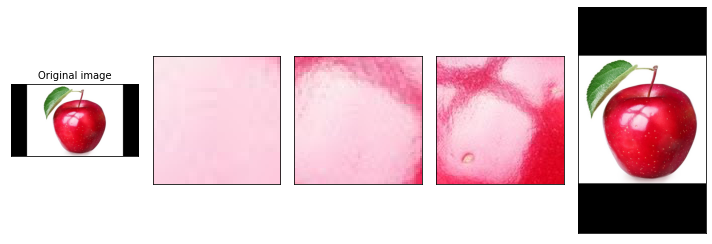

In [ ]:
center_crops = [transforms.CenterCrop(size=size)(orig_img) for size in (32,64,128, orig_img.size)]
plot(center_crops)

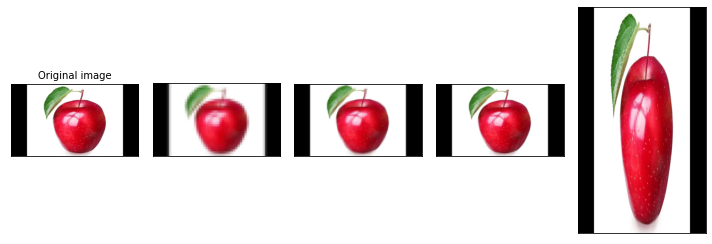

In [ ]:
resized_imgs = [transforms.Resize(size=size)(orig_img) for size in (32, 64, 128, orig_img.size)]
plot(resized_imgs)

In [ ]:
resized_imgs

[<PIL.Image.Image image mode=RGB size=56x32 at 0x7F23E2883CD0>,
 <PIL.Image.Image image mode=RGB size=113x64 at 0x7F23E2883F50>,
 <PIL.Image.Image image mode=RGB size=227x128 at 0x7F23E2883D10>,
 <PIL.Image.Image image mode=RGB size=720x1280 at 0x7F23E28891D0>]

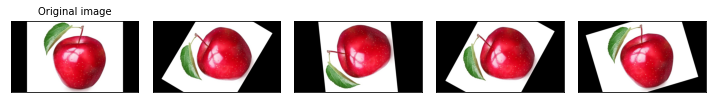

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
rotater = transforms.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot(rotated_imgs)

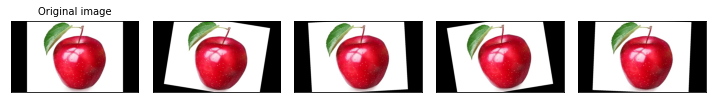

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
rotater = transforms.RandomRotation(10)
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot(rotated_imgs)

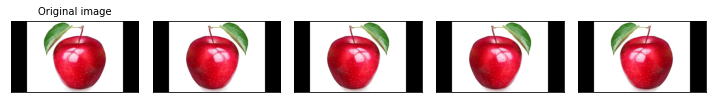

In [ ]:
hflipper = transforms.RandomHorizontalFlip()
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)

### Data loader 

In [ ]:
#https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html?highlight=imagefolder#torchvision.datasets.ImageFolder
#A generic data loader where the images are arranged in this way by default: root/dog/xxx.png , 

traindata = ImageFolder(train_path, transform=train_transform, loader=custom_pil_loader)
valdata = ImageFolder(val_path, transform=train_transform, loader=custom_pil_loader)
testdata = ImageFolder(test_path, transform=test_transform, loader=custom_pil_loader)

In [ ]:
print("Total imagenes Train:", len(traindata))
print("Total imagenes Test:",len(testdata))
print("Total imagenes Validacion:",len(valdata))

Total imagenes Train: 3115
Total imagenes Test: 359
Total imagenes Validacion: 351


In [ ]:
# Vemos el size de las imagenes
img, label = traindata[20]
print(img.shape)
img, label = testdata[50]
print(img.shape)
img, label = valdata[20]
print(img.shape)

torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


In [ ]:
# Function for the showing the image.
def show_image(img,label):
    print('Label: ', traindata.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  banana (1)


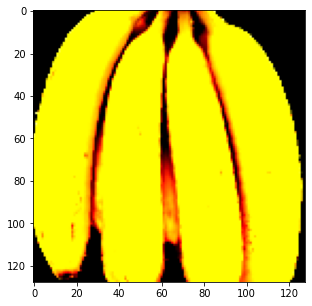

In [ ]:
plt.rcParams["figure.figsize"] = (5,5)
show_image(*traindata[125])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  apple (0)


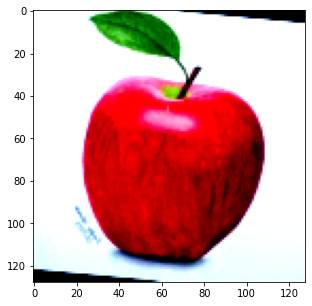

In [ ]:
show_image(*traindata[13])

In [ ]:
def plot_figure(image):
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: kiwi


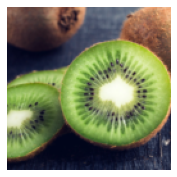

In [ ]:
# Muestra random
rnd_sample_idx = np.random.randint(len(testdata))
print(f'La imagen muestreada representa un: {classes[testdata[rnd_sample_idx][1]]}')
image = testdata[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

## Definición del modelo
En este caso vamos a crear una clase que hereda de nn.Module. Esto permite encapsular funcionalidades y hacer más simple los ciclos de entrenamiento y evaluación

In [ ]:
# Batch Size: este es el número de ejemplos que se introducen en la red para que entrene de cada vez. 
# Si el número es pequeño, significa que la red tiene en memoria poca cantidad de datos, y entrena más rápido
BATCH_SIZE = 64
train_loader = DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(testdata, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


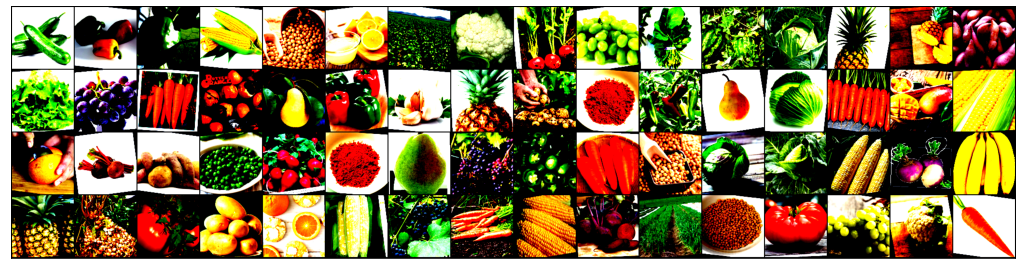

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [ ]:
class CNNVegetal(nn.Module):
    def __init__(self, nclasses, input_channels, device=device):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
  
        self.fc = nn.Sequential(
            nn.Linear(86528, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, nclasses)
        )
        
        self.loss_func = nn.CrossEntropyLoss()
        self.optim = tr.optim.Adam(self.parameters(), lr=0.001)

        self.device = device
        self.to(device)

    def forward(self, x):
        x = self.cnn(x)
        x = tr.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc(x)
        return x


    def fit(self, loader, verbose=False):
        """Función de entrenamiento (una época)"""
        epoch_loss = 0
        if verbose:
            loader = tqdm(loader)
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            
            yhat = self.forward(x)
            loss = self.loss_func(yhat, y)
            
            epoch_loss += loss.item()

            self.optim.zero_grad()
            loss.backward() 
            self.optim.step()

        return epoch_loss/len(loader)


    def test(self, loader):
        """Función de evaluación (una época)"""
        epoch_loss = 0
        ref, pred = [], []
        for x, y in loader:
            with tr.no_grad():
                x, y = x.to(self.device), y.to(self.device)
                yhat = self.forward(x)

                # predicciones y referencias para calcular tasa de acierto
                ref.append(y.cpu())
                pred.append(tr.argmax(yhat.cpu(), dim=1))

            loss = self.loss_func(yhat, y)
            epoch_loss += loss.item()
            
        bal_acc = balanced_accuracy_score(tr.cat(ref), tr.cat(pred))

        return epoch_loss/len(loader), bal_acc
        
net = CNNVegetal(nclasses=36, input_channels=3, device=device)
net

CNNVegetal(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=86528, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=36, bias=True)
  )
  (loss_func): CrossEntropyLoss()
)

## Entrenamiento
Realizar el entrenamiento recorriendo varias veces el dataset (épocas). Se implementa una forma de early-stop: cuando el loss de validación no se mejora en una serie de épocas, se detiene el entrenamiento. 

**Nota**: Solo se guarda el modelo en los puntos donde la validación resulta ser mejor   

In [ ]:
#Tres canales
log = []
best_loss, counter, patience = 999, 0, 3
for epoch in range(30):
    train_loss = net.fit(train_loader, verbose=True)
    val_loss, val_acc = net.test(val_loader)

    if val_loss < best_loss:    
        best_loss = val_loss
        tr.save(net.state_dict(), '/content/drive/MyDrive/MCD/Redes Neuronales/model.pmt')
        counter = 0
    else:
        counter += 1
        if counter > patience:
            break
            
    print(f'Epoch {epoch}, train_loss {train_loss:.2f}, val_loss {val_loss:.2f}, val_acc {val_acc:.2f}')
    log.append([train_loss, val_loss, val_acc])

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 0, train_loss 3.42, val_loss 2.97,  val_acc 0.13


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1, train_loss 2.91, val_loss 2.47,  val_acc 0.24


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2, train_loss 2.66, val_loss 2.28,  val_acc 0.28


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3, train_loss 2.43, val_loss 2.04,  val_acc 0.38


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4, train_loss 2.30, val_loss 1.90,  val_acc 0.42


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5, train_loss 2.18, val_loss 1.60,  val_acc 0.49


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 6, train_loss 2.02, val_loss 1.50,  val_acc 0.52


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 7, train_loss 1.90, val_loss 1.43,  val_acc 0.54


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 8, train_loss 1.77, val_loss 1.36,  val_acc 0.58


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 9, train_loss 1.65, val_loss 1.15,  val_acc 0.67


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 10, train_loss 1.54, val_loss 1.04,  val_acc 0.67


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 11, train_loss 1.45, val_loss 1.02,  val_acc 0.69


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 12, train_loss 1.34, val_loss 0.89,  val_acc 0.72


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 13, train_loss 1.21, val_loss 0.81,  val_acc 0.75


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 14, train_loss 1.15, val_loss 0.66,  val_acc 0.79


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 15, train_loss 1.03, val_loss 0.79,  val_acc 0.74


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 16, train_loss 0.95, val_loss 0.69,  val_acc 0.79


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 17, train_loss 0.84, val_loss 0.64,  val_acc 0.82


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 18, train_loss 0.85, val_loss 0.67,  val_acc 0.84


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 19, train_loss 0.82, val_loss 0.60,  val_acc 0.83


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 20, train_loss 0.67, val_loss 0.67,  val_acc 0.84


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 21, train_loss 0.63, val_loss 0.45,  val_acc 0.91


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 22, train_loss 0.65, val_loss 0.57,  val_acc 0.85


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 23, train_loss 0.56, val_loss 0.47,  val_acc 0.87


  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 24, train_loss 0.58, val_loss 0.46,  val_acc 0.89


  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
log

[[3.4224485183248716, 2.969149390856425, 0.1302469135802469],
 [2.90554217416413, 2.469835082689921, 0.23611111111111116],
 [2.6626870340230515, 2.275708476702372, 0.2777777777777777],
 [2.4262683926796424, 2.0385693113009133, 0.37530864197530867],
 [2.3025458394264686, 1.9020699858665466, 0.41975308641975306],
 [2.1823963729702696, 1.6043858726819356, 0.48580246913580244],
 [2.0171826226370677, 1.498158613840739, 0.5166666666666667],
 [1.900672462521767, 1.428071121374766, 0.5419753086419754],
 [1.7691869443776655, 1.3568865060806274, 0.5805555555555554],
 [1.654244639435593, 1.1464589635531108, 0.6660493827160493],
 [1.5405424857626155, 1.0401789446671803, 0.674074074074074],
 [1.454068578019434, 1.0166049003601074, 0.6895061728395062],
 [1.33778343395311, 0.8881105283896128, 0.7169753086419755],
 [1.2090353831952931, 0.8109019647041956, 0.7459876543209876],
 [1.15328506061009, 0.6627359837293625, 0.7895061728395062],
 [1.0347126272259926, 0.7861341834068298, 0.7410493827160493],
 [0

In [ ]:
np.save('/content/drive/MyDrive/MCD/Redes Neuronales/log.npy', log)

In [ ]:
netValues = np.load('/content/drive/MyDrive/MCD/Redes Neuronales/log.npy')
print(netValues)

[[3.42244852 2.96914939 0.13024691]
 [2.90554217 2.46983508 0.23611111]
 [2.66268703 2.27570848 0.27777778]
 [2.42626839 2.03856931 0.37530864]
 [2.30254584 1.90206999 0.41975309]
 [2.18239637 1.60438587 0.48580247]
 [2.01718262 1.49815861 0.51666667]
 [1.90067246 1.42807112 0.54197531]
 [1.76918694 1.35688651 0.58055556]
 [1.65424464 1.14645896 0.66604938]
 [1.54054249 1.04017894 0.67407407]
 [1.45406858 1.0166049  0.68950617]
 [1.33778343 0.88811053 0.71697531]
 [1.20903538 0.81090196 0.74598765]
 [1.15328506 0.66273598 0.78950617]
 [1.03471263 0.78613418 0.74104938]
 [0.94759538 0.69086127 0.78919753]
 [0.84470728 0.64412436 0.81574074]
 [0.84730411 0.66750045 0.84074074]
 [0.82120662 0.59752942 0.8345679 ]
 [0.66972407 0.67429642 0.84197531]
 [0.63005588 0.45299585 0.90802469]
 [0.64787012 0.56510762 0.85123457]
 [0.55824373 0.47029347 0.86944444]
 [0.57929234 0.45697368 0.88796296]]


In [ ]:
len(netValues)

25

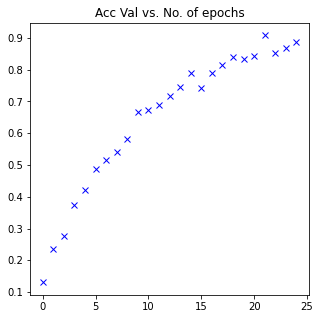

In [ ]:
for i in range(0,len(netValues)):
  x = np.arange(0, len(netValues), 1)
  plt.plot(x[i],netValues[i][2], '-bx')
  plt.title('Acc Val vs. No. of epochs')

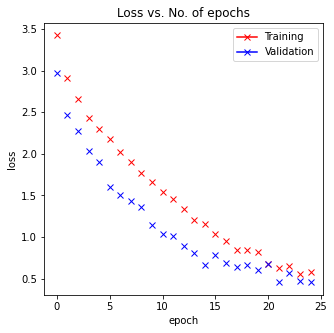

In [ ]:
for i in range(0,len(netValues)):
  x = np.arange(0, len(netValues), 1)
  plt.plot(x[i],netValues[i][0],'-rx')
  plt.plot(x[i],netValues[i][1],'-bx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs')

## Evaluación
Tomamos la partición de test independiente para evaluar nuestro modelo

In [ ]:
net = CNNVegetal(nclasses=36, input_channels=3, device=device)

# carga de parámetros
net.load_state_dict(tr.load("/content/drive/MyDrive/MCD/Redes Neuronales/model.pmt"))
net.eval()

test_loss, test_acc = net.test(test_loader)
   
t = PrettyTable(['Test Loss', 'Test Acc'])
t.add_row([round(test_loss, 2), round(test_acc, 2)])

print(t)

+-----------+----------+
| Test Loss | Test Acc |
+-----------+----------+
|    0.3    |   0.95   |
+-----------+----------+


Se carga una imagen de prueba para testear el modelo:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tamaño torch.Size([1, 3, 128, 128]) min -2.0357141494750977 max 2.640000104904175


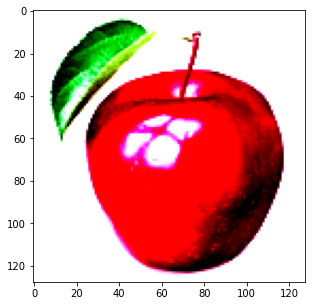

In [ ]:
img=Image.open("/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_2.jpg")
label_names=classes
normalize = transforms.Compose([
                            transforms.Resize(128), 
                            transforms.CenterCrop(128),                                                
                            transforms.ToTensor(),                                                    
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])                         

x = normalize(img).unsqueeze(0)
print("Tamaño", x.shape, "min", x.min().item(), "max", x.max().item())
plt.imshow(x.squeeze().permute(1,2,0))

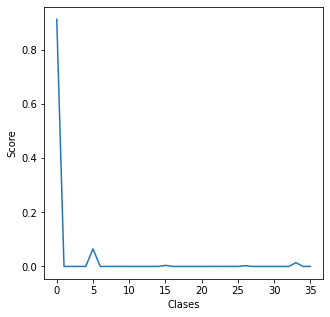

In [ ]:
#Se usa la red entrenada para generar un vector de activaciones. Serán 36 neuronas y se aplica Softmax.
#Se grafican las clases con mayor importancia:

for images, labels in test_loader:
  with tr.no_grad():
    y = net(x.type(torch.cuda.FloatTensor)).squeeze()
    probs = softmax(y)
plt.plot(probs.cpu())
plt.ylabel("Score")
plt.xlabel("Clases");

In [ ]:
# Analizamos los scores de las 3 clases más relevantes:
ind = tr.argsort(probs)

#t = PrettyTable(['Primer Clase', 'Segunda Clase', 'Tercera Clase'])
t = PrettyTable([label_names[ind[-1]].strip(),label_names[ind[-2]].strip(), label_names[ind[-3]].strip()])
t.add_row([round(probs[ind[-1]].item(), 2),round(probs[ind[-2]].item(), 2), round(probs[ind[-3]].item(), 2)])

print(t)


+-------+----------+--------+
| apple | capsicum | tomato |
+-------+----------+--------+
|  0.91 |   0.06   |  0.01  |
+-------+----------+--------+


## Reporte de clasificacion

In [ ]:
pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = net(x.type(torch.cuda.FloatTensor)).squeeze()
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       0.83      1.00      0.91        10
           4       1.00      1.00      1.00        10
           5       0.80      0.80      0.80        10
           6       1.00      1.00      1.00        10
           7       0.91      1.00      0.95        10
           8       1.00      0.80      0.89        10
           9       0.90      0.90      0.90        10
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       0.91      1.00      0.95        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

In [ ]:
# Guardar el reporte en un csv

#report_dict = classification_report(Y, pred, output_dict=True)

#dataframe = pd.DataFrame(report_dict)

#dataframe.transpose().to_csv('/content/drive/MyDrive/MCD/Redes Neuronales/report.csv')


# Predicciones 

In [ ]:
paths0=[]
for dirname, _, filenames in os.walk("/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test"):
    for filename in filenames:
        paths0+=[os.path.join(dirname, filename)]
paths=sorted(paths0)
print(paths[0:10])

['/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_1.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_10.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_2.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_3.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_4.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_5.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_6.JPG', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_7.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_8.jpg', '/content/drive/MyDrive/MCD/Redes Neuronales/dataset/test/apple/Image_9.jpg']


In [ ]:
# Test loader prediction result
Test_Pred=pd.DataFrame(columns=['path','True Class','Class Predicted'])
Test_Pred['path']=paths
Test_Pred['True Class']=Y
Test_Pred['Class Predicted']=pred
display(Test_Pred)

,path,True Class,Class Predicted
0,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
1,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
2,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
3,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
4,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,28
...,...,...,...
354,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35
355,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35
356,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35
357,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35


In [ ]:
# Guarda el Test_Pred en un csv

#Test_Pred.to_csv('/content/drive/MyDrive/MCD/Redes Neuronales/TestPred.csv')


In [4]:
test_pred=pd.read_csv("/content/drive/MyDrive/MCD/Redes Neuronales/TestPred.csv")
test_pred=test_pred.drop("Unnamed: 0", axis=1)

In [5]:
test_pred["Class Predicted"]

,path,True Class,Class Predicted
0,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
1,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
2,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
3,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,0
4,/content/drive/MyDrive/MCD/Redes Neuronales/da...,0,28
...,...,...,...
354,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35
355,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35
356,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35
357,/content/drive/MyDrive/MCD/Redes Neuronales/da...,35,35


In [11]:
# Reemplazo los numeros por el nombre de la categoria
vector=np.arange(0,len(classes),1)
vector=vector.tolist()
dict_from_list = dict(zip(vector,classes))
print(dict_from_list)

{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}


In [12]:
test_pred=test_pred.replace(dict_from_list)

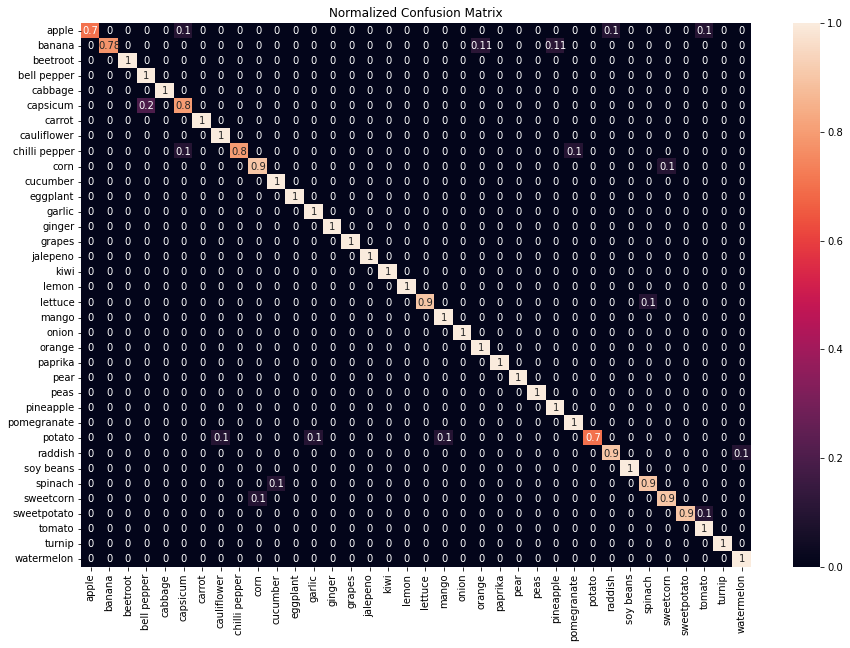

In [13]:
cf_matrix = confusion_matrix(test_pred["True Class"], test_pred["Class Predicted"], normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(test_pred["True Class"])), 
            yticklabels = sorted(set(test_pred["True Class"])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [15]:
#Agrego la columna para ver los nombres de las carpetas (control nada mas)
paths_=list(test_pred["path"])
new_list_path=[]
for i in range(0,len(paths_)):
    splitted_ds = paths_[i].split("Redes Neuronales/")
    file_name = splitted_ds[1]
    new_list_path.append(file_name)
test_pred["path reducido"]=new_list_path

In [16]:
test_pred

,path,True Class,Class Predicted,path reducido
0,/content/drive/MyDrive/MCD/Redes Neuronales/da...,apple,apple,dataset/test/apple/Image_1.jpg
1,/content/drive/MyDrive/MCD/Redes Neuronales/da...,apple,apple,dataset/test/apple/Image_10.jpg
2,/content/drive/MyDrive/MCD/Redes Neuronales/da...,apple,apple,dataset/test/apple/Image_2.jpg
3,/content/drive/MyDrive/MCD/Redes Neuronales/da...,apple,apple,dataset/test/apple/Image_3.jpg
4,/content/drive/MyDrive/MCD/Redes Neuronales/da...,apple,raddish,dataset/test/apple/Image_4.jpg
...,...,...,...,...
354,/content/drive/MyDrive/MCD/Redes Neuronales/da...,watermelon,watermelon,dataset/test/watermelon/Image_5.jpg
355,/content/drive/MyDrive/MCD/Redes Neuronales/da...,watermelon,watermelon,dataset/test/watermelon/Image_6.jpg
356,/content/drive/MyDrive/MCD/Redes Neuronales/da...,watermelon,watermelon,dataset/test/watermelon/Image_7.jpg
357,/content/drive/MyDrive/MCD/Redes Neuronales/da...,watermelon,watermelon,dataset/test/watermelon/Image_8.jpg


In [21]:
random.seed(5)
def random_sample(df, num_images):
    ran_sample=df.sample(n=num_images)
    ran_sample=ran_sample.reset_index()
    return ran_sample

In [22]:
#Visualizo un ejemplo de dataset (por control para las imagenes)
random_sample(test_pred , 15)

,index,path,True Class,Class Predicted,path reducido
0,53,/content/drive/MyDrive/MCD/Redes Neuronales/da...,capsicum,capsicum,dataset/test/capsicum/Image_4.jpg
1,112,/content/drive/MyDrive/MCD/Redes Neuronales/da...,eggplant,eggplant,dataset/test/eggplant/Image_3.jpg
2,54,/content/drive/MyDrive/MCD/Redes Neuronales/da...,capsicum,bell pepper,dataset/test/capsicum/Image_5.jpg
3,193,/content/drive/MyDrive/MCD/Redes Neuronales/da...,mango,mango,dataset/test/mango/Image_4.jpg
4,325,/content/drive/MyDrive/MCD/Redes Neuronales/da...,sweetpotato,sweetpotato,dataset/test/sweetpotato/Image_6.jpg
5,3,/content/drive/MyDrive/MCD/Redes Neuronales/da...,apple,apple,dataset/test/apple/Image_3.jpg
6,104,/content/drive/MyDrive/MCD/Redes Neuronales/da...,cucumber,cucumber,dataset/test/cucumber/Image_5.jpg
7,310,/content/drive/MyDrive/MCD/Redes Neuronales/da...,sweetcorn,sweetcorn,dataset/test/sweetcorn/Image_10.jpg
8,222,/content/drive/MyDrive/MCD/Redes Neuronales/da...,paprika,paprika,dataset/test/paprika/Image_3.jpg
9,273,/content/drive/MyDrive/MCD/Redes Neuronales/da...,potato,potato,dataset/test/potato/Image_4.jpg


In [19]:
def visualize_model(num_rows, num_cols, num_images, test_pred):
    plt.figure(figsize=(10, 10))
    ran_sample=random_sample(test_pred , num_images)
    for i in range(0,len(ran_sample)):
        plt.subplot(num_rows, num_cols, i+1)
        img=Image.open(ran_sample["path"][i])
        plt.imshow(img)
        plt.axis('off')
        if ran_sample.loc[i,"True Class"]== ran_sample.loc[i,"Class Predicted"]:
            check = 'green'
        else: check = 'red'
    
        plt.title(f'Pred: {ran_sample.loc[i,"Class Predicted"]}', color='white',
              backgroundcolor=check, fontsize=15)
        i+=1
        if i==len(ran_sample):
            break

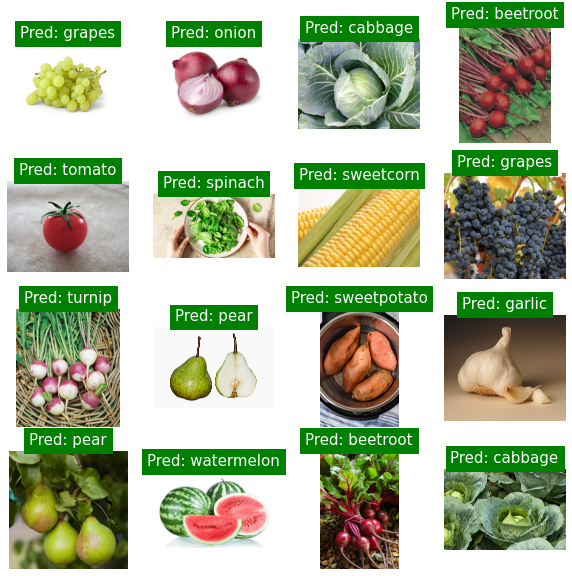

In [23]:
visualize_model(4, 4, 16, test_pred)